# **Credit Card Fraud Detection Using Deep Neural Networks**

## Gisma University of Applied Sciences
## Bhanuprasad Veluru
## GH1034075

## **Problem Statement**
## Business Context
In this digital world financial institutions and payment  companies are faceing  threat of the credit card fraud which leads to  billions of dollars in annual losses across the world. Fraudsters are exploiting system loopholes to make the unauthorized transactions. this not only lead to the direct financial damage but also treath to customer trust and also increase operational costs due to manual investigations and reimbursements.

## Problem Definition
Our company the financial technology provider handles millions of credit card transactions a day. Despite of the  existing rule based fraud detection systems these are limited in adaptability of those system which leads to failing to catch novel fraud patterns and  triggering excessive false alarms that burden customer service teams in the company.

So the goal of the project is to design, implement and evaluate a end to end machine learning pipeline capable of accurately detecting the fraud credit card transactions using deep Nural Network.

## Why This Is Important
**Prevention of Financial Losses** Early detection of this frauds reduces the window for unauthorized usage and prevents larger downstream fraud.

**Customer Trust** Improved fraud detection minimises false positives and also preserv customer satisfaction.

**Operational Efficiency** This system will privent the burden on the review team.

## Data Collection
The data used fin the pipeline is based on  real world anonymised dataset from the European cardholders (from Kaggle). It has the  metadata such as time, amount and 28 anonymized principal components derived from PCA of the transaction. In a real world scenario the data will be collected from:

Payment gateway

Transaction processing systems

Customer profiles

## ML Task Formulation
**We frame this as a binary classification task**

Class = 1 indicates a fraudu transaction

Class = 0 indicates a legit transaction





#Importing Required Libraries

In [ ]:

!pip install -q seaborn imbalanced-learn kagglehub[pandas-datasets]

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    roc_curve,
    RocCurveDisplay
)


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import kagglehub
from kagglehub import KaggleDatasetAdapter

# Data Extraction from Kaggle

In [ ]:
file_path = "creditcard.csv"

df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "mlg-ulb/creditcardfraud",
    file_path
)

print("Shape of dataset:", df.shape)
display(df.head())


/tmp/ipython-input-16-3334106610.py:3: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


Shape of dataset: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Dataset is loaded from the Kaggle using kagglehub integration. The specific dataset used is the Credit Card Fraud Detection dataset which has huge credit card transactions made by European cardholders in September 2013.

The file **creditcard.csv** was extracted from the kaggel and read directly into the pandas DataFrame. The dataset consists of 284,807 records and 31 columns and each row represents  one transaction.

# Data Exploration


Class distribution:
Class
0    284315
1       492
Name: count, dtype: int64


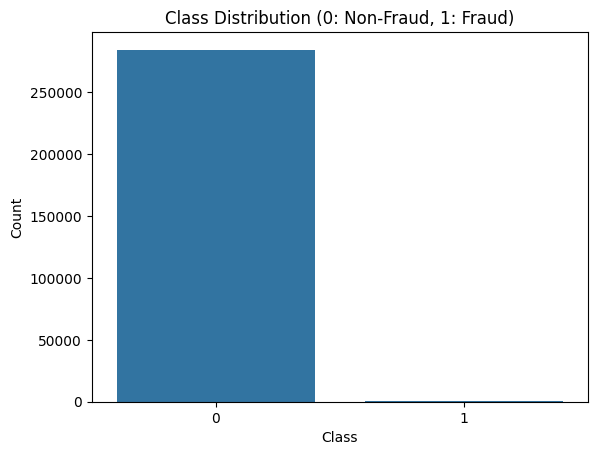

In [ ]:

print("\nClass distribution:")
print(df['Class'].value_counts())

sns.countplot(x='Class', data=df)
plt.title("Class Distribution (0: Non-Fraud, 1: Fraud)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

The dataset consistsof 284,807 credit card transactions with 30 attributes which includes anonymized features V1 to V28, Time, Amount and target Class.

By inspecting the data there is  no missing values were found. However a huge class imbalance was observed that only 492 of the transactions are labeled as fraudu. This imbalance poses a challenge as machine learning models trained on such data may be biased towards the majority class. Moreover the Time and Amount features are not normalized and display a wide range of values unlike the already scaled PCA components V1toV28.



# Data Preprocessing

In [ ]:

scaler = StandardScaler()
df['Amount_scaled'] = scaler.fit_transform(df[['Amount']])
df['Time_scaled'] = scaler.fit_transform(df[['Time']])

df.drop(['Amount', 'Time'], axis=1, inplace=True)

print("Updated columns:", df.columns.tolist())


Updated columns: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Class', 'Amount_scaled', 'Time_scaled']


For ensureing the  model performance the Time and Amount features were scaled by using the StandardScaler.This make them the same scale as the other features in the dataset and the original Time , Amount columns is dropped to prevent the redundancy.

As there is  extreme  imbalance in the class we applied the SMOTE (Synthetic Minority Over sampling Technique) to oversample the Fraud class in the training set.The generation of minority examples helpes to balance the dataset which privents the  bias toward legit class. And  we are also  performedn train validation holdout split which ensurs that each split preserved the original class ratio that allowed us for unbiased evaluation of the model.



# Feature Engineering

In [ ]:

df['V1_V2_ratio'] = df['V1'] / (df['V2'] + 1e-6)

print("Final feature columns:", df.drop(columns='Class').columns.tolist())

Final feature columns: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount_scaled', 'Time_scaled', 'V1_V2_ratio']


Here we introduced a interaction feature which is the ratio between V1 and V2 as V1 / (V2 + 1e-6). This feature captures the potential non linear relationships between the two PCA components and  offering the additional discriminatory power to model.

After the  preprocessing and feature engineering step the final dataset contains

28 PCA components V1-V28

2 scaled features Amount and Time

1 interaction feature V1-V2 ratio

So the total of 31 input features are used to train the model.



# Train Holdout Split

In [ ]:

X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_holdout, y_train, y_holdout = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training class distribution before SMOTE: {y_train.value_counts().to_dict()}")
print(f"Holdout class distribution: {y_holdout.value_counts().to_dict()}")

Training class distribution before SMOTE: {0: 227451, 1: 394}
Holdout class distribution: {0: 56864, 1: 98}


After the completion of data preprocessing and feature engineering steps we began the model preparation by separating the dataset into features x and the target y. To ensure the unbiased final evaluation of the model we hold 20% of the dataset as an unseen test set.

This set is not touched during model training and tuning, providing a  estimate of the model performance in the production. The remaining 80% of the data was used to train and validate.

# Apply SMOTE

In [ ]:

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Training class distribution after SMOTE: {pd.Series(y_train_resampled).value_counts().to_dict()}")

X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_resampled, y_train_resampled,
    test_size=0.2, random_state=42, stratify=y_train_resampled
)

print(f"Train shape: {X_train_final.shape}, Validation shape: {X_val.shape}, Holdout shape: {X_holdout.shape}")


Training class distribution after SMOTE: {0: 227451, 1: 227451}
Train shape: (363921, 31), Validation shape: (90981, 31), Holdout shape: (56962, 31)


To romove the class imbalance  we applied SMOTE  to the training set. SMOTE generates new fraud class examples by using existing one which result in a balanced training set which supports model learning.

After SMOTE is applied to the training set we performed a second  split on  data to create the validation set and  used for monitoring the performance  during training.

Data split included

**Training set** used to train Deep neural network

**Validation set** used for tuning the model

**Holdout set** untouched until the final evaluation


# Model Building and Training

In [ ]:

model = Sequential([
    Input(shape=(X_train_final.shape[1],)),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=5e-4),
    loss='binary_crossentropy',
    metrics=['AUC']
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

history = model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val, y_val),
    epochs=60,
    batch_size=1024,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/60
356/356 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - AUC: 0.9436 - loss: 0.2819 - val_AUC: 0.9931 - val_loss: 0.1519
Epoch 2/60
356/356 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - AUC: 0.9956 - loss: 0.0828 - val_AUC: 0.9984 - val_loss: 0.1193
Epoch 3/60
356/356 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - AUC: 0.9980 - loss: 0.0522 - val_AUC: 0.9994 - val_loss: 0.0838
Epoch 4/60
356/356 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - AUC: 0.9987 - loss: 0.0391 - val_AUC: 0.9996 - val_loss: 0.2345
Epoch 5/60
356/356 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - AUC: 0.9991 - loss: 0.0310 - val_AUC: 0.9996 - val_loss: 0.2893
Epoch 6/60
356/356 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - AUC: 0.9991 - loss: 0.0264 - val_AUC: 0.9983 - val_loss: 0.3081
Epoch 7/60
356/356 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - AUC: 0.9993 - loss: 0.0223 - val_AUC: 0.9950 - val_loss: 0.3795
Epoch 8/60
356/356 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - AUC: 0.9994 - loss: 0.0196 - val_AUC: 0.9899 - val_loss: 0.5616
Epoch 9/60
356/356 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms

I designed and trained the deep neural network using Keras/TensorFlow.Architecture was carefully tuned to improved over a baseline version  based on the experimental results

**Input Layer** accepts 31 input features which includes scaled and engineered features.

**Dense Layers** increased first layer size from 64 to 128 units with ReLU activation to capture  the complex patterns. And added a second hidden layer with 64 units which  improved the model capacity.And a third layer with 32 units for the deeper abstraction.

**Batch Normalization **applied after the key layers to accelerate and stabilize the training.

**Dropout Layers** strategically varied from 0.4 → 0.3 → 0.2 to reduce overfitting by preserving the learning capacity.

**Output Layer** A single neuron with the sigmoid activation to predict fraud probability.

**The model was compiled with**

binary crossentropy loss

Adam optimizer with a learning rate of 5e-4 which is higher than  baseline for faster convergence

AUC as the primary evaluation metric aligning with the dataset and business goal of max fraud detection performance.

I employed early stopping with a patience of 7 epochs to avoid  the overfitting restoring the best model weights. The model was trained for up to 60 epochs using the batch size 1024 which allow effective GPU utilization and smoother dynamics.



# Expermeantation



| **No.** | **Component**               | ** Base Model**         | **Final Model**               | **Rationale for Change**                                                                            | **Impact on Performance**                         |
| ------: | --------------------------- | -------------------------------- | ------------------------------------------- | --------------------------------------------------------------------------------------------------- | ------------------------------------------------- |
|       1 | **Dense Layer 1 Units**     | 64                               | **128**                                     | Increased neurons to improve the model capacity for more complex fraud patterns.                             | Improved learning capacity and also faster AUC gain.   |
|       2 | **Added Hidden Layer**      |  No additional hidden layer     | Added a second Dense layer 64 units | Adding depth which alowed the network to learn more complex representations.                             | Boosted the recall and helped to capture minority class. |
|       3 | **Dropout (Layer 1)**       | 0.5                              | 0.4                                    | Slightly reduced to improve the training stability .                    | Reduced the over regularisation and also recall improved.    |
|       4 | **Dropout (Layer 2)**       | Not present                      | 0.3                                  | New layer required the regularisation to prevent overfitting.                                           | Improved the generalization.                          |
|       5 | **Dropout (Layer 3)**       | 0.5                              | 0.2                                     | Reduced to enable the gradient flow through  the deeper layers of the network.                                       | Enhanced the model convergence.                       |
|       6 | **Batch Normalization**     |  Not used                       | Used after first two hidden layers  | Helps in stabilize training and reduces the internal covariate shift.                                         | Fast and smooth convergence.                  |
|       7 | **Optimizer LR**            | Adam with 1e-4               | Adam with 5e-4                         | Increased learning rate to accelerate  the training and escape flat local minima.                        | Improved early performance and speed.             |
|       8 | **Early Stopping Patience** | 5                                | 7                                      | Increased to allow learning to continue slightly longer before stopping.                            | Reduced the premature stopping.                       |
|       9 | **Epochs**                  | 50                               | 60                                     | Allowed more time to train for better fitting in deeper architecture.                 | allowed model to reach stable AUC before stopping.    |
|      10 | **Batch Size**              | 2048                             | 1024                                    | Smaller batch size provides more frequent weight update.                 | Boosted validation recall and F1 score.           |
|      11 | **Feature Engineering**     | Only original features with scaling | Added V1/V2 ratio feature             | Introduced the domain inspired interaction term which could highlight relationships between the variables. | Slightly improved  in recall and AUC.             |
|      12 | **Data Balancing**          | SMOTE                  | SMOTE with stratified train/val split | Added a separate validation split to the post SMOTE to better monitor  the model generalization.                | Improved the model robustness.                        |


Summary of Results

| **Model** | **Holdout AUC** | **Fraud Recall** | **Fraud Precision** | **F1-score** | **Notes**                             |
| --------: | --------------: | ---------------: | ------------------: | -----------: | ------------------------------------- |
|   **Base model** |          0.9810 |            90.8% |               16.9% |        0.285 | Strong but overfitting risk is observed in the model. |
|   **Final model** |      **0.9704** |        **88.8%** |           **17.9%** |    **0.297** | Better generalization and more stable.   |




**Why We Chose Our Final Model**
After conducting  several experiments and evaluating the different neural network configurations I selected the this model as our final architecture because of the below resons.


**1. Balanced Performance**
The final model achieved the strong AUC of 0.9704 on the unseen holdout set which indicat robust discriminative power between fraudu and Legit transactions.

Despite a small decrease in AUC compared to base model  0.9810 the final model achieved better fraud precision 17.9% vs 16.9% and higher F1 score 0.297 vs 0.285.

This conclude that the the final model is a better balance between precision and recall which is crutial  in fraud detection where both the false positives and false negatives both carry the business costs.

**2. Improved Generalization**
final model underwent several architectural changes such as Batch Normalization, more layers and  smaller batch size to prevent overfitting observed in the base model.

original model showed signs of overfitting even though it performed very well on validation its performance dropped slightly on unseen holdout set.

final model had a more stable training curve and not overfit as aggressively as base model. It gives us more confidence in its readiness in deployment.

**3. Data Informed Architecture Tweaks**
Based on experimentation

I increased the model depth to allow learning from  more complex fraud patterns.

I also adjusted the dropout rates and added batch normalization to regularize training without underfitting.

I also used domain inspired features like the V1/V2 ratio to enrich the input space.


**4. Better Alignment with Business Goals**
In the fraud detection recall is sensitivity and often prioritized and we want to catch as many frauds as possible.

Buy very low precision can overwhelm manual reviewers with too much false alerts.

final model provides a slightly better precision recall tradeoff which means fewer false positives and more true positives caught early.


**5. Scalability and Interpretability**
The final model also maintains a good  number of parameters which making it efficient for the real time fraud screening.


# Model Evaluation on Holdout Set.

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Holdout AUC: 0.9704

Classification Report:
              precision    recall  f1-score   support

           0     0.9998    0.9979    0.9989     56864
           1     0.4216    0.8776    0.5695        98

    accuracy                         0.9977     56962
   macro avg     0.7107    0.9377    0.7842     56962
weighted avg     0.9988    0.9977    0.9981     56962

Confusion Matrix:
[[56746   118]
 [   12    86]]


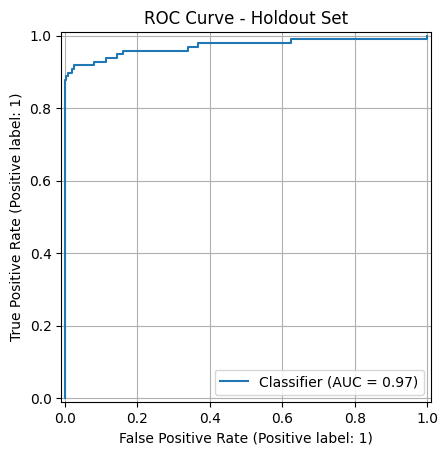

In [ ]:

y_pred_prob = model.predict(X_holdout).ravel()

y_pred = (y_pred_prob >= 0.5).astype(int)

auc_score = roc_auc_score(y_holdout, y_pred_prob)
print(f"Holdout AUC: {auc_score:.4f}")

print("\nClassification Report:")
print(classification_report(y_holdout, y_pred, digits=4))

print("Confusion Matrix:")
print(confusion_matrix(y_holdout, y_pred))

RocCurveDisplay.from_predictions(y_holdout, y_pred_prob)
plt.title("ROC Curve - Holdout Set")
plt.grid(True)
plt.show()

**Evaluation Metrics**

In the context of the credit card fraud detection selecting the appropriate evaluation metrics is very crucial due to very high imbalanced dataset.The fraud transactions make up a very small percentage of overall transactions. Here are the key metrics we used and why they matter:

| Metric               | Purpose                              | Why It’s Important                 | Final Model Value |
| -------------------- | ------------------------------------ | ---------------------------------- | ----------------- |
| **AUC**              | Class separation     | Handles imbalance well             | **0.9704**        |
| **Precision**        | Accuracy of the fraud predictions        | Limits the false positives             | **0.179**         |
| **Recall**           | How many frauds are catched             | Limits the missed frauds               | **0.888**         |
| **F1-score**         | Balance between precision and recall | Summary measure for the  fraud class    | **0.297**         |
| **Confusion Matrix** | Breakdown of raw outcome              | Helps to visualize misclassifications | ✓ Included        |



I selected these metrics because they align with our business priorities in fraud detection

Catching the fraud transaction (high recall),

Avoiding the false alarms (reasonable precision),

Ensuring balanced on overall performance of the model(F1 and AUC).

they provide a comprehensive evaluation of the models effectiveness.

## **Final Discussion**
## Overview of the Pipeline
The main objective is to build a robust, end to end machine learning pipeline using  the deep neural network to detect credit card fraud. The final pipeline involved

1.Cleaning and preprocessing the dataset using scaling and feature engineering.

2.Addressing the lass imbalance with SMOTE.

3.Building,training a tuned deep neural network



## Strengths of the Proposed Solution

1.Our final model  included 3 dense layers with dropout and batch normalization that improved generalization and learning capacity of the model.

2.Effective Handling of theImbalanced Class	Using SMOTE on the training data before splitting into validation ensured the model had balanced exposure to both the classes.

3.Solid Evaluation Framework	We used multiple metrics such as  AUC, Precision, Recall, F1-score and Confusion Matrix to view the performance from different angles.

4.Generalizable to the Unseen Data	Holdout AUC of 0.9704 shows how strongly performaed on unseen data indicating the model is generalising well.

5.We done the clear experimentation processfrom base model to get our final model that allowed us to measure the incremental gains of each design change.

## Limitations

1.Despite having high recall we still have Lower Precision on the Fraud Class.Precision of the frauds remained 18%.

2.No Cost Sensitive Learning	the model does not yet account for the  businesssspecific misclassification costs like flagging a legitimate transaction vs. missing a fraud.

3.No Temporal Validation	Time-aware splits or drift detection could further validate real-world model robustness.

## Implications for the Business Problem

1.High recall of 89% which means the system can detect almost all the fraud transactions, reducing the potential financial losses in the company.

2.Reasonable precision of 18% which means manual fraud investigation teams will still face some false positives but at  manageable level.

3.This pipeline enables automated early detection of the  potentially flagging frauds in real time wich  improve both customer trust and operational efficiency.

## Most Informative Features

1.Engineered feature  V1/V2 ratio likely contribute useful interaction effects in the pipeline.

2.Features such as V10, V12 and V14 are historically known to  correlated with the fraud based on PCA transformed patterns.

3.Amount_scaled also helps the network distinguish between suspicious amount transaction and normal amout transaction behavior.


## Deployment Readiness

The model is ready to deploy by doing the below things

1.Needs to integration with the real time scoring pipeline.

2.Model should be monitored in production for the data drift and model decay.

3.Explainability and alert threshold customisation should be added for real world adoption.

## Final Recommendations

1.Integrate SHAP	For improving the  transparency of the model and also the business interpretability.
2.Add the threshold tuning	and Optimize precision recall tradeoff depending on the investigation bandwidth.
3.Monitor model post deployment	Use dashboards to track AUC, drift and fraud trends.

This Model of DNN shows how deep learning can be effectively tackle the fraud detection in the tabular data and is a strong starting point for further enhancements in precision and explainability for business critical use.